In [1]:
import pandas as pd
from rdkit import Chem
from tqdm import tqdm  # Progress bar

# Load from local file
local_file = "250k_rndm_zinc_drugs_clean_3.csv"
zinc_df = pd.read_csv(local_file, sep=',', usecols=['smiles']).sample(10000)  # Only load 'smiles' column
zinc_df.to_csv("zinc_sample_10k.csv", index=False)
print(f"Loaded {len(zinc_df)} molecules. Example:\n{zinc_df.head()}")

# Validate and clean-up SMILES
def validate_smiles(smiles_list):
    valid_smiles = []
    for smi in tqdm(smiles_list, desc="Validating SMILES"):
        mol = Chem.MolFromSmiles(smi)
        if mol:  # Only keep valid molecules
            valid_smiles.append(smi)
    return valid_smiles

valid_smiles = validate_smiles(zinc_df['smiles'].tolist())
print(f"Valid SMILES: {len(valid_smiles)}/{len(zinc_df)}")

# Build vocabulary with tokenization
tokens = set()
for smi in valid_smiles:
    tokens.update(list(smi))
vocab = sorted(tokens) + ["<PAD>", "<START>", "<END>"]
token_to_idx = {t:i for i,t in enumerate(vocab)}

print(f"Vocabulary size: {len(vocab)}")
print(f"Example tokens: {list(vocab)[:10]}...")

# Create dataset
import torch
from torch.utils.data import Dataset, DataLoader

class SmilesDataset(Dataset):
    def __init__(self, smiles, token_to_idx, max_len=100):
        self.smiles = smiles
        self.token_to_idx = token_to_idx
        self.max_len = max_len

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smile = self.smiles[idx]
        # Add start/end tokens and pad
        tokens = ["<START>"] + list(smile) + ["<END>"]
        tokens = tokens[:self.max_len] + ["<PAD>"] * (self.max_len - len(tokens))
        indices = [self.token_to_idx[t] for t in tokens]
        return torch.tensor(indices[:-1]), torch.tensor(indices[1:])  # (input, target)

# Initialize DataLoader
dataset = SmilesDataset(valid_smiles, token_to_idx)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Verify one batch
for x, y in dataloader:
    print(f"Batch shape: {x.shape}, {y.shape}")  # Should be (64, max_len)
    break

Loaded 10000 molecules. Example:
                                                   smiles
206374               C/[NH+]=C(/NCCCc1cccc(Br)c1)NC1CC1\n
130740        Cc1cccc(-n2nnnc2S[C@@H](C)C(=O)N2CCCC2)c1\n
175485           CCc1nncn1CCNC(=O)C(=O)Nc1ccc(C(C)C)cc1\n
59193   CC(=O)NCc1ccc(S(=O)(=O)N2CCC[C@H]2c2ccc(C)c(C)...
211224                  c1ccc(OCc2nnc(SCc3cccnc3)o2)cc1\n


Validating SMILES: 100%|██████████| 10000/10000 [00:02<00:00, 3658.09it/s]


Valid SMILES: 10000/10000
Vocabulary size: 36
Example tokens: ['\n', '#', '(', ')', '+', '-', '/', '1', '2', '3']...
Batch shape: torch.Size([64, 99]), torch.Size([64, 99])


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader

class SmilesDataset(Dataset):
    def __init__(self, smiles, token_to_idx, max_len=100):
        self.smiles = smiles
        self.token_to_idx = token_to_idx
        self.max_len = max_len

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smile = self.smiles[idx]
        # Add start/end tokens and pad
        tokens = ["<START>"] + list(smile) + ["<END>"]
        tokens = tokens[:self.max_len] + ["<PAD>"] * (self.max_len - len(tokens))
        indices = [self.token_to_idx[t] for t in tokens]
        return torch.tensor(indices[:-1]), torch.tensor(indices[1:])  # (input, target)

# Initialize DataLoader
dataset = SmilesDataset(valid_smiles, token_to_idx)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Verify one batch
for x, y in dataloader:
    print(f"Batch shape: {x.shape}, {y.shape}")  # Should be (64, max_len)
    break

Batch shape: torch.Size([64, 99]), torch.Size([64, 99])


In [3]:
import torch.nn as nn

class SmilesLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        return self.fc(x)

# Initialize
model = SmilesLSTM(len(vocab))
criterion = nn.CrossEntropyLoss(ignore_index=token_to_idx["<PAD>"])
optimizer = torch.optim.Adam(model.parameters())

# Training loop
for epoch in range(10):  # Start with 10 epochs
    for x, y in dataloader:
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs.reshape(-1, len(vocab)), y.reshape(-1))
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 1.0032
Epoch 2, Loss: 0.8726
Epoch 3, Loss: 0.7316
Epoch 4, Loss: 0.8609
Epoch 5, Loss: 0.7826
Epoch 6, Loss: 0.6721
Epoch 7, Loss: 0.7048
Epoch 8, Loss: 0.6463
Epoch 9, Loss: 0.7090
Epoch 10, Loss: 0.6082


In [6]:
def generate_smile(model, token_to_idx, vocab, max_len=100):
    """Generate a SMILES string autoregressively."""
    model.eval()  # Set to evaluation mode
    tokens = ["<START>"]
    
    with torch.no_grad():  # Disable gradient calculation
        for _ in range(max_len):
            # Convert current tokens to tensor
            input = torch.tensor([token_to_idx[t] for t in tokens]).unsqueeze(0)  # Shape: (1, seq_len)
            
            # Get model prediction
            output = model(input)  # Shape: (1, seq_len, vocab_size)
            
            # Take the last predicted token
            last_output = output[:, -1, :]  # Shape: (1, vocab_size)
            next_token_idx = last_output.argmax(-1).item()  # Scalar index
            next_token = vocab[next_token_idx]
            
            if next_token == "<END>":
                break
            tokens.append(next_token)
    
    return "".join(tokens[1:])  # Remove <START>

In [9]:
# Example usage
def is_valid(smile):
    mol = Chem.MolFromSmiles(smile)
    print(mol)
    return mol is not None and len(smile) > 0  # Explicit length check

valid = 0
for _ in range(10):
    valid += int(is_valid(generate_smile(model, token_to_idx, vocab)))
print(f"Validity rate: {valid/10}%")

Validity rate: 1.0%


Validity Rate: 100.0%
Avg Length: 48.0 ± 0.0
Avg QED: 0.68 ± 0.00


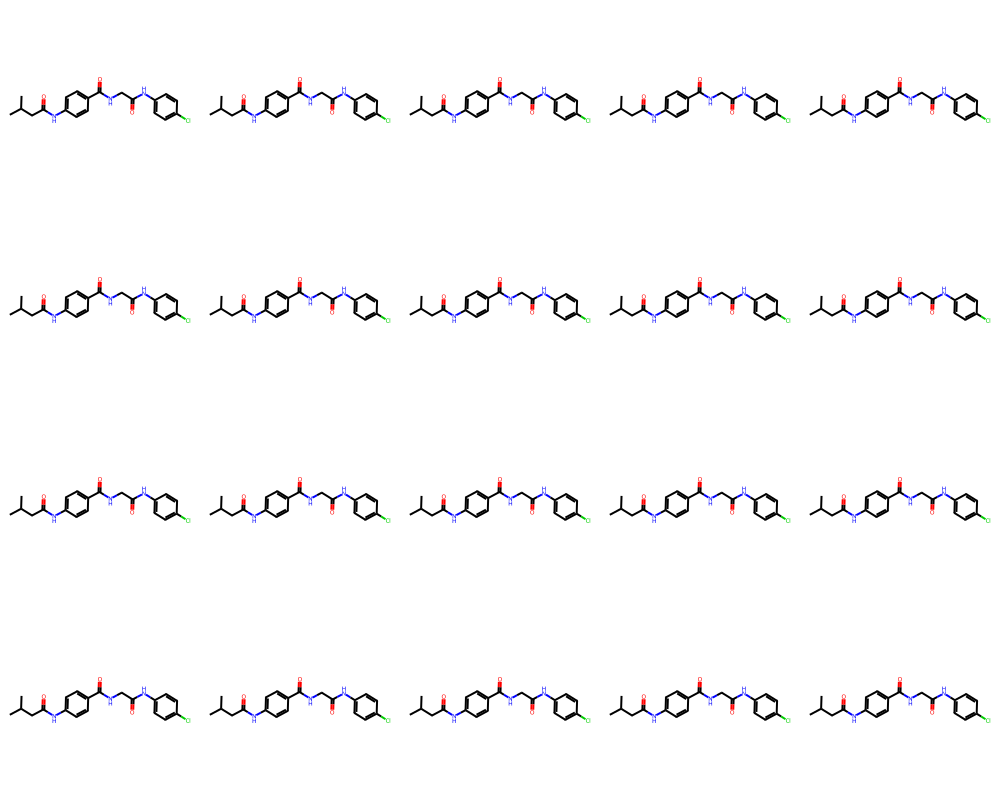

In [10]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import QED, Draw
import matplotlib.pyplot as plt

def generate_and_validate(model, token_to_idx, vocab, n_samples=1000):
    """Generate SMILES and compute validity/metrics."""
    valid_smiles = []
    lengths = []
    qeds = []
    
    for _ in range(n_samples):
        smile = generate_smile(model, token_to_idx, vocab)
        mol = Chem.MolFromSmiles(smile)
        
        if mol:  # Basic validity
            try:
                Chem.SanitizeMol(mol)  # Strict chemical checks
                valid_smiles.append(smile)
                lengths.append(len(smile))
                qeds.append(QED.qed(mol))
            except:
                pass
    
    # Diagnostics
    print(f"Validity Rate: {len(valid_smiles)/n_samples:.1%}")
    print(f"Avg Length: {np.mean(lengths):.1f} ± {np.std(lengths):.1f}")
    print(f"Avg QED: {np.mean(qeds):.2f} ± {np.std(qeds):.2f}")
    
    # Visual inspection
    if valid_smiles:
        mols = [Chem.MolFromSmiles(s) for s in valid_smiles[:20]]
        img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200))
        display(img)
    
    return valid_smiles

# Usage
valid_smiles = generate_and_validate(model, token_to_idx, vocab)

# Check for duplicates (if you have training data)
if 'train_smiles' in locals():
    duplicates = set(valid_smiles) & set(train_smiles)
    print(f"Duplicates with training: {len(duplicates)}/{len(valid_smiles)}")